<a href="https://colab.research.google.com/github/DiwakarBasnet/Style_Transfer/blob/main/neuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Dependencies and Pretrained Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import cv2
import PIL

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

print(tf.__version__)

2.9.2


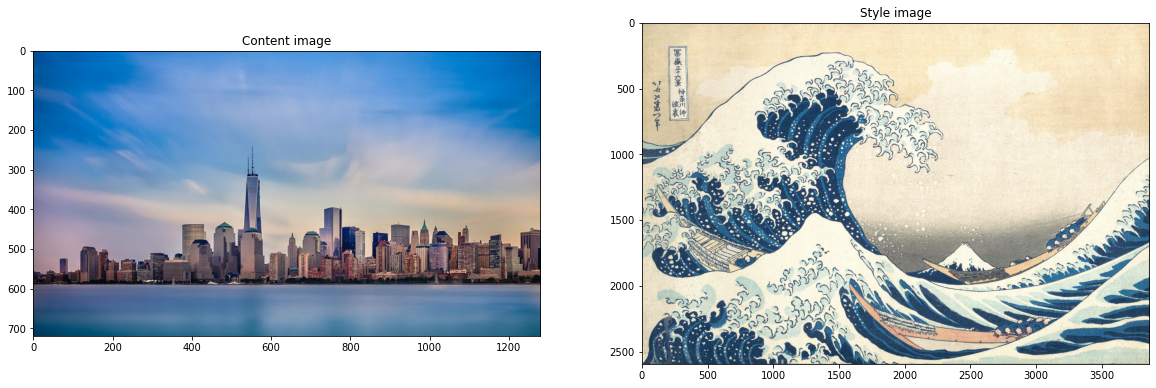

In [2]:
# Load content and style images
content = plt.imread('skyline.jpg')
style = plt.imread('great-wave.jpg')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style image side-by-side
ax1.imshow(content)
ax1.set_title('Content image')
ax2.imshow(style)
ax2.set_title('Style image')
plt.show()

In [3]:
# Function to load 2 images in arrays of numbers and reshape them in model compatible form
# Model takes image in format (1, dim, dim, 3)
def load_image(image):
  image = cv2.resize(cv2.imread(image), (400, 400))
  img = tf.image.convert_image_dtype(image, tf.float32)
  # img =  tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :]  # adds new axis in beginning of tensor
  # img = img[:,:,:,:3]    # takes channel 3 instead of 4
  return img

In [4]:
content = load_image('skyline.jpg')
style = load_image('great-wave.jpg')

# verify the shape
content.shape, style.shape

(TensorShape([1, 400, 400, 3]), TensorShape([1, 400, 400, 3]))

## Load model and custom model creation

In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
# include_top -> as we are using model for feature extraction, we won't need classifier part so false
# weights -> we are using weights used by VGG19 on "imagenet" dataset
vgg.trainable = False
# False - we want our model to train on our image instead of images used while training model

80134624/80134624 [==============================] - 0s 0us/step


In [6]:
# Print the layer names
for layer in vgg.layers:
  print(layer.name)

# 16 conv layers and 5 pool layers

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [7]:
# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Now create custom VGG model which will be composed of specified layers. This will help to run forward passes on the images and extract the necessary features along the way.

In [8]:
def mini_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

## Gram Matrix
A gram matrix is matrix created by dot product of matrix created by vectors of feature maps with its own transpose.
$$G_{ij}^l = \sum_{k} F_{ik}^l F_{jk}^l$$

In [9]:
def gram_matrix(input_tensor):
  # temp = tf.squeeze(input_tensor)   # removes dimensions of size 1 from shape of tensor
  temp = input_tensor
  result = tf.matmul(temp, temp, transpose_b=True)  # transpose b matrix before matrix multiplication
  gram = tf.expand_dims(result, axis=0)  # returns a tensor with a length 1 axis inserted at index axis
  return gram

## Custom class
Using mini_model() function custom class is defined which will be used to return content and style features from the respective images.

In [10]:
from tensorflow.python.types.core import Value
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg = mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  @tf.function()
  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    # Assign the content representation and gram matrix in a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [11]:
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [12]:
# Adam optimizer
opt = tf.optimizers.Adam(learning_rate=0.02)

In [13]:
# Custom weights for style and content updates
style_weight = 100   # Beta
content_weight = 10  # Alpha

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

## Loss Function
* Total loss: $$L_{total} \left( S,C,G \right) = α L_{content} \left( C,G \right) + β L_{style} \left( S,G \right)$$
* Content loss: $$L_{content} \left( p,x,l \right) =  {1 \over 2} \sum_{ij} \left( F_{ij}^l - P_{ij}^l \right)^2$$
* Style loss:  $$E_l = {1 \over 4 N_l^2 M_l^2} \sum_{ij} \left( G_{ij}^l - A_{ij}^l \right)^2$$
$$L_{style} \left( a,x \right) = \sum_{l=0}^L w_l * E_l$$

In [14]:
# The loss function to optimize
def total_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  
  # tf.add_n - gets the sum of style loss from list(summation)
  style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                         for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers    # Normalize

  # content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2
  #                                         for name in content_outputs.keys())])
  content_loss = tf.reduce_mean((content_outputs['block4_conv2'] - content_targets['block4_conv2'])**2)
  # content_loss = tf.add_n([tf.reduce_mean((content_outputs['block4_conv2']-content_targets['block4_conv2'])**2)])
  content_loss *= content_weight / num_content_layers    # Normalize
  
  loss = style_loss + content_loss
  return loss

We will now write another function which will:
* Calculate the gradients of the loss function we just defined.
* Use these gradients to update the target image.

With GradientTape, we can take advantage of automatic differentiation, which can calculate the gradients of a function based on its composition. We will also use the tf.function decorator to speed up the operations.

When a function is decorated with @tf.function(), Tensorflow will convert the python function into a Tensorflow graph, which can be executed much more efficiently than the original Python code.

In [15]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

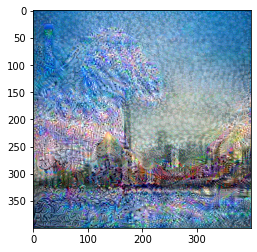

In [18]:
target_image = tf.Variable(content)
epochs = 10
steps_per_epoch = 100
step = 0

for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)

tensor = target_image*255
tensor = np.array(tensor, dtype=np.uint8)
if np.ndim(tensor)>3:
  assert tensor.shape[0] == 1
  tensor = tensor[0]
tensor = PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))
plt.show()